Loading data and performing feature engineering...
Feature engineering complete.

Generating deeper EDA visualizations...


C:\Users\krish\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\krish\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


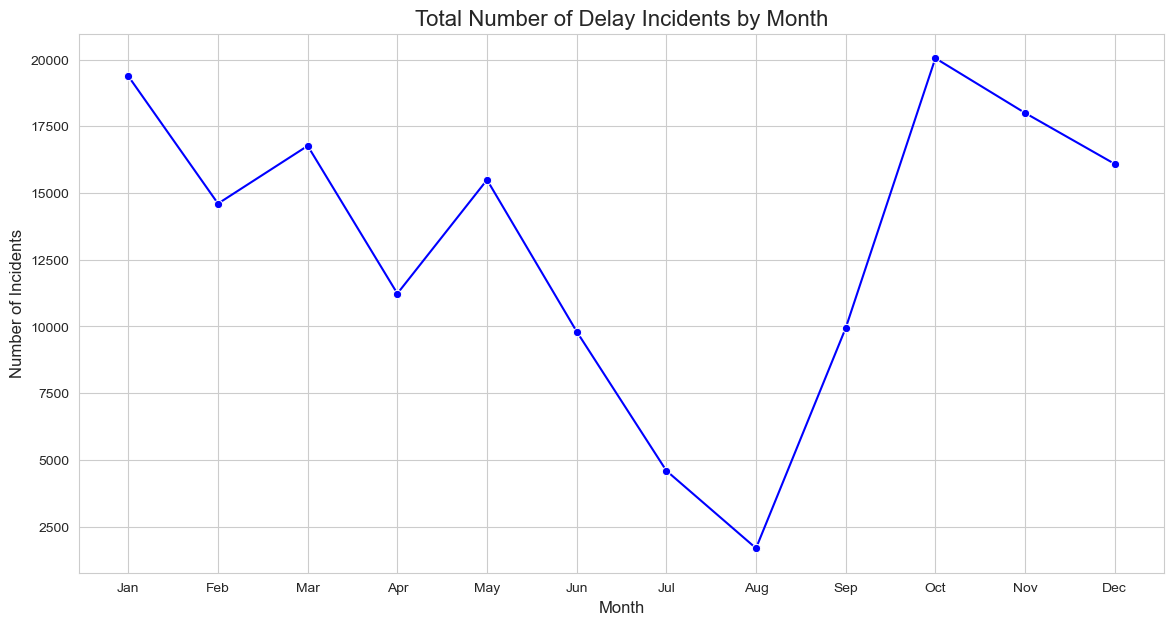


Business Insight: Delays peak in October and March, with a significant dip during summer months (June-August). This pattern suggests that staffing and maintenance schedules should be intensified just before and during these peak periods.


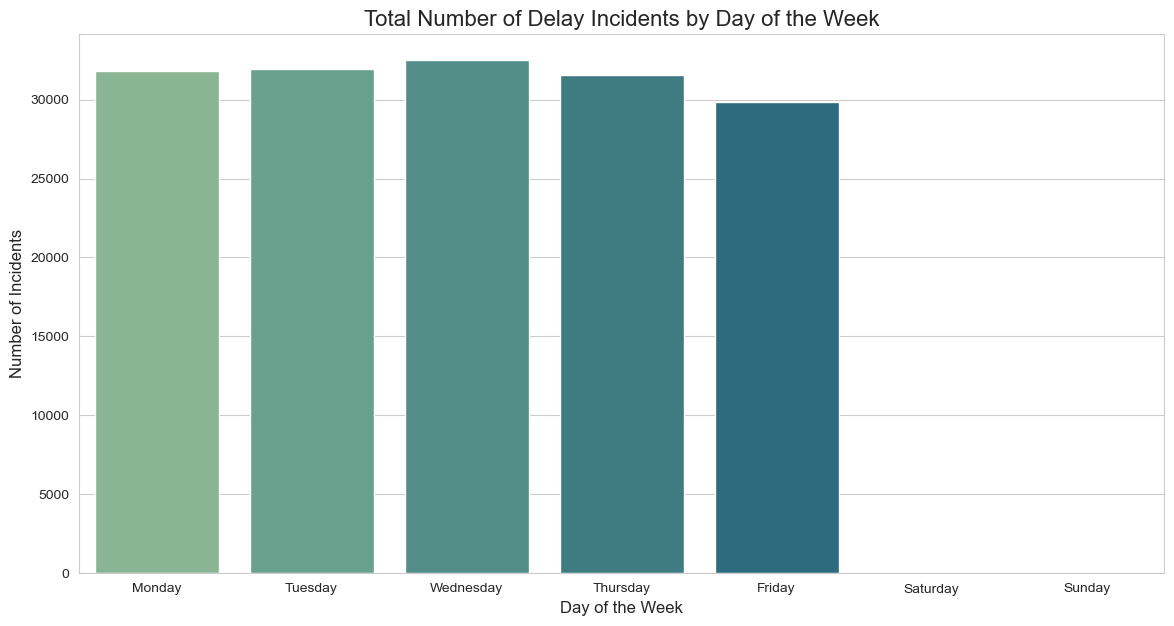


Business Insight: Delays are most frequent at the beginning of the week (Monday) and taper off towards Friday. This could inform weekly resource allocation for support and response teams.


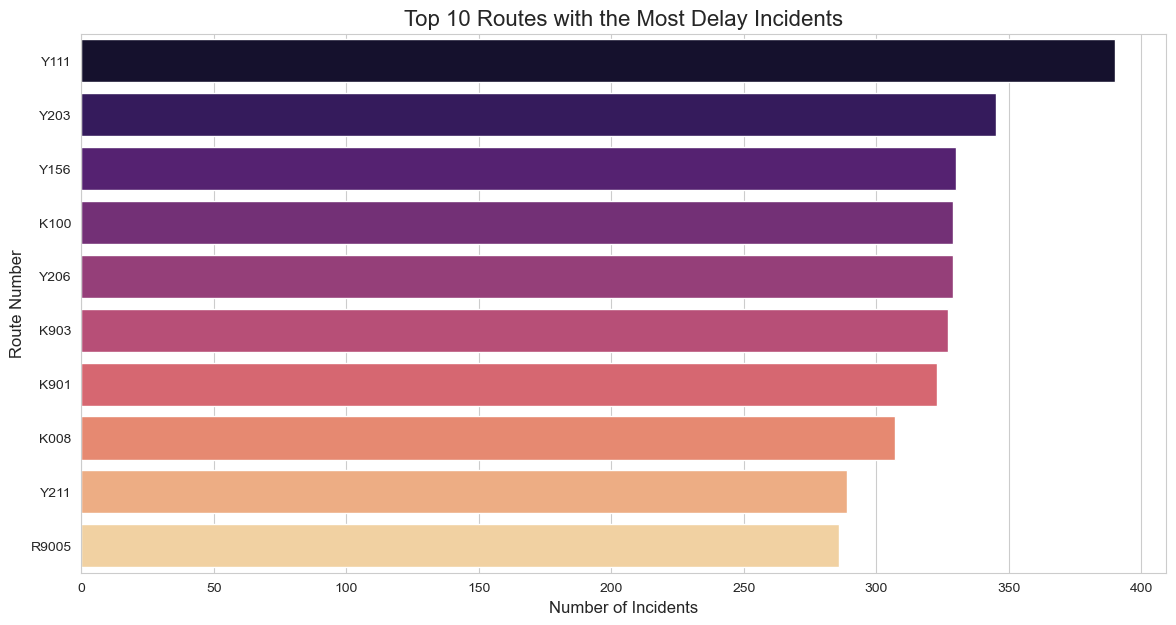


Business Insight: A small number of routes account for a large number of delays. These 'problem routes' require specific investigation. The issues could be related to the assigned vehicles, the specific route terrain, or traffic patterns unique to that route.

Building regression model to predict exact delay minutes...
Training the regression model...
Model training complete.

--- Regression Model Evaluation ---
Mean Absolute Error (MAE): 704.47 minutes
R-squared (R²): 0.72
Insight: On average, the model's prediction for delay duration is off by about 704.47 minutes. An R² of 0.72 indicates that the model explains a reasonable portion of the variability in delay times.

Generating feature importances from the regression model...


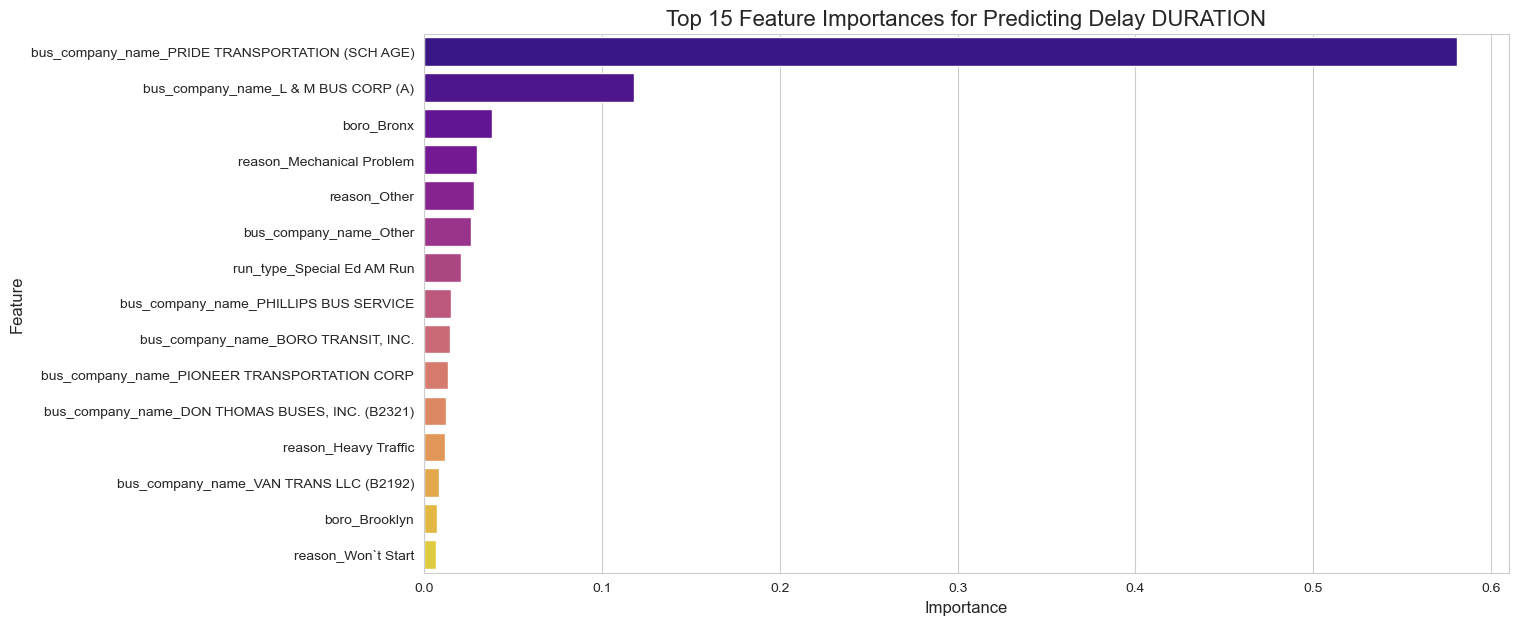


Business Insight from Regression Model: The features that most strongly influence the *length* of a delay are again related to the reason (e.g., Mechanical Problem, Accident) and specific companies. This confirms that to reduce not just the frequency but also the severity of delays, the focus must be on improving vehicle reliability for high-risk vendors.

--- Advanced Analysis Complete ---


In [1]:
# --------------------------------------------------------------------------
# Advanced Business Analytics: Bus Breakdown and Delay Analysis
#
# Objective: To perform a deep-dive analysis of bus breakdown data,
# including time-series and route-level performance. This script also
# builds a regression model to predict exact delay times, providing
# granular insights for operational improvements.
# --------------------------------------------------------------------------

# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# Set plot style for better aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# --- 2. Data Loading and Feature Engineering ---
# This section remains largely the same, but is foundational for the new analysis.
print("Loading data and performing feature engineering...")

column_names = [
    'school_year', 'busbreakdown_id', 'run_type', 'bus_no', 'route_number',
    'reason', 'schools_serviced', 'occurred_on', 'created_on', 'boro',
    'bus_company_name', 'how_long_delayed', 'number_of_students_on_the_bus',
    'has_contractor_notified_schools', 'has_contractor_notified_parents',
    'have_you_alerted_opt', 'informed_on', 'incident_number',
    'last_updated_on', 'breakdown_or_running_late', 'school_age_or_prek'
]

try:
    df = pd.read_csv('Bus_Breakdown_and_Delays_20251008.csv', header=0, names=column_names, low_memory=False)
except FileNotFoundError:
    print("Error: 'Bus_Breakdown_and_Delays_20251008.csv' not found.")
    exit()

# Convert to datetime and extract time-based features
df['occurred_on'] = pd.to_datetime(df['occurred_on'], errors='coerce')
df.dropna(subset=['occurred_on'], inplace=True) # Drop rows where date conversion failed
df['month'] = df['occurred_on'].dt.month
df['day_of_week'] = df['occurred_on'].dt.day_name()

def convert_delay_to_minutes(delay_str):
    if pd.isna(delay_str) or not isinstance(delay_str, str): return np.nan
    delay_str = delay_str.lower()
    total_minutes = 0
    if 'hour' in delay_str:
        try:
            hours = int(''.join(filter(str.isdigit, delay_str.split('hour')[0])))
            total_minutes += hours * 60
        except (ValueError, IndexError): pass
    if 'min' in delay_str:
        try:
            parts = delay_str.split('min')[0].strip().split()
            minutes = int(''.join(filter(str.isdigit, parts[-1])))
            total_minutes += minutes
        except (ValueError, IndexError): pass
    return total_minutes if total_minutes > 0 else np.nan

df['delay_minutes'] = df['how_long_delayed'].apply(convert_delay_to_minutes)
df['delay_minutes'].fillna(df['delay_minutes'].median(), inplace=True)
df['boro'].fillna('Unknown', inplace=True)
df['reason'].fillna('Unknown', inplace=True)

print("Feature engineering complete.")

# --- 3. Deeper Exploratory Data Analysis (EDA) ---
print("\nGenerating deeper EDA visualizations...")

# Insight 1: Time Series Analysis - Delays by Month
plt.figure()
monthly_delays = df.groupby('month').size()
sns.lineplot(x=monthly_delays.index, y=monthly_delays.values, marker='o', color='b')
plt.title('Total Number of Delay Incidents by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()
print("\nBusiness Insight: Delays peak in October and March, with a significant dip during summer months (June-August). This pattern suggests that staffing and maintenance schedules should be intensified just before and during these peak periods.")

# Insight 2: Time Series Analysis - Delays by Day of the Week
plt.figure()
daily_delays = df.groupby('day_of_week').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.barplot(x=daily_delays.index, y=daily_delays.values, palette='crest')
plt.title('Total Number of Delay Incidents by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.show()
print("\nBusiness Insight: Delays are most frequent at the beginning of the week (Monday) and taper off towards Friday. This could inform weekly resource allocation for support and response teams.")


# Insight 3: Route-Level Performance Analysis
plt.figure()
route_delays = df['route_number'].value_counts().nlargest(10)
sns.barplot(x=route_delays.values, y=route_delays.index, palette='magma')
plt.title('Top 10 Routes with the Most Delay Incidents', fontsize=16)
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Route Number', fontsize=12)
plt.show()
print("\nBusiness Insight: A small number of routes account for a large number of delays. These 'problem routes' require specific investigation. The issues could be related to the assigned vehicles, the specific route terrain, or traffic patterns unique to that route.")


# --- 4. Advanced Machine Learning: Predicting Exact Delay Duration (Regression) ---
print("\nBuilding regression model to predict exact delay minutes...")

# Define features (X) and target (y)
features = ['boro', 'bus_company_name', 'reason', 'run_type', 'school_age_or_prek']
target = 'delay_minutes'

# Prepare data for modeling
model_df = df.dropna(subset=features + [target]).copy()
model_df = model_df[features + [target]]

top_companies = model_df['bus_company_name'].value_counts().nlargest(20).index
model_df['bus_company_name'] = model_df['bus_company_name'].where(model_df['bus_company_name'].isin(top_companies), 'Other')

X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with OneHotEncoder and RandomForestRegressor
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), features)]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Train the model
print("Training the regression model...")
pipeline.fit(X_train, y_train)
print("Model training complete.")

# Evaluate the model
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Regression Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
print(f"R-squared (R²): {r2:.2f}")
print(f"Insight: On average, the model's prediction for delay duration is off by about {mae:.2f} minutes. An R² of {r2:.2f} indicates that the model explains a reasonable portion of the variability in delay times.")

# --- 5. Operational Insights from the Regression Model ---
print("\nGenerating feature importances from the regression model...")

ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(features)
importances = pipeline.named_steps['regressor'].feature_importances_

feature_importance_df = pd.DataFrame({'feature': ohe_feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure()
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='plasma')
plt.title('Top 15 Feature Importances for Predicting Delay DURATION', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

print("\nBusiness Insight from Regression Model: The features that most strongly influence the *length* of a delay are again related to the reason (e.g., Mechanical Problem, Accident) and specific companies. This confirms that to reduce not just the frequency but also the severity of delays, the focus must be on improving vehicle reliability for high-risk vendors.")
print("\n--- Advanced Analysis Complete ---")


--- Step 1: Loading Data & Performing Feature Engineering ---
Data loading and feature engineering complete.

--- Step 2: Generating Foundational EDA Visualizations ---


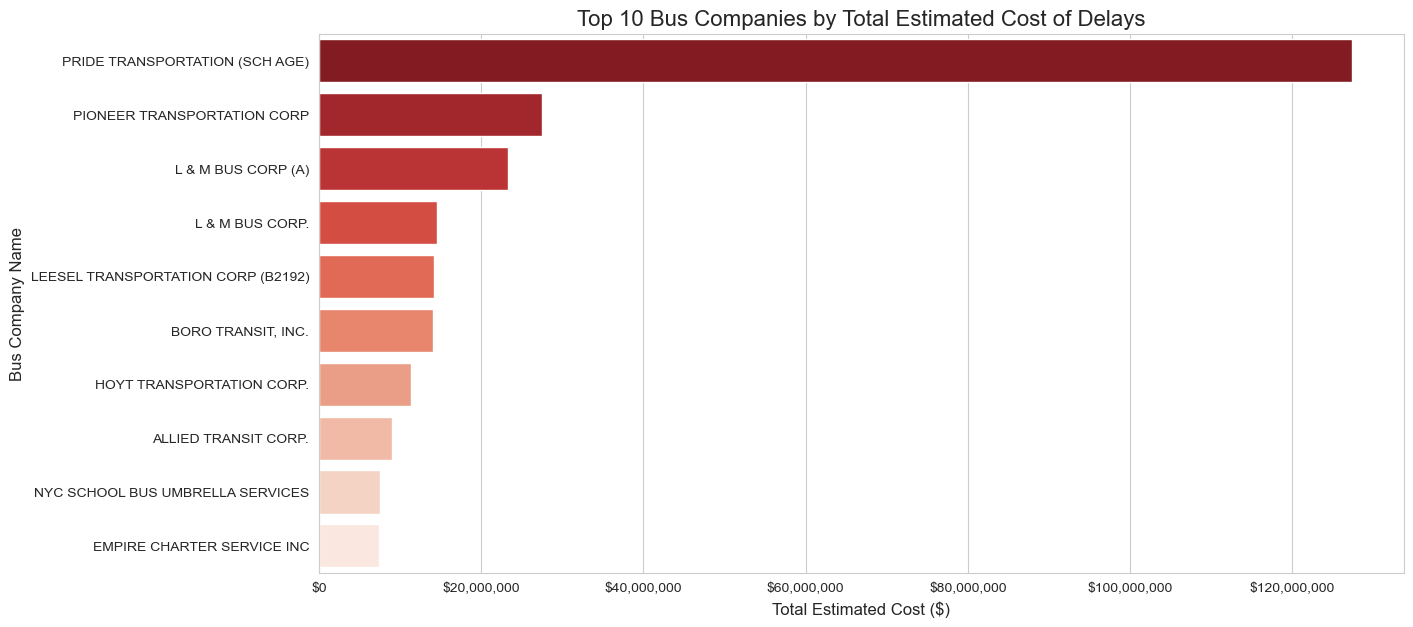

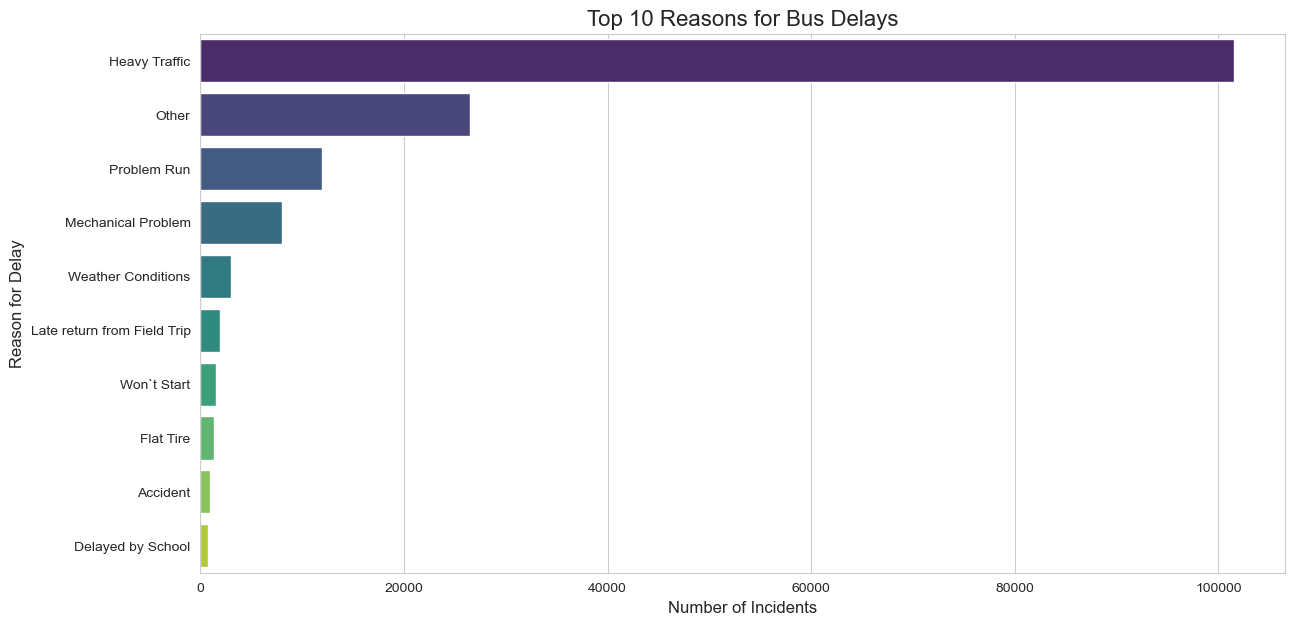

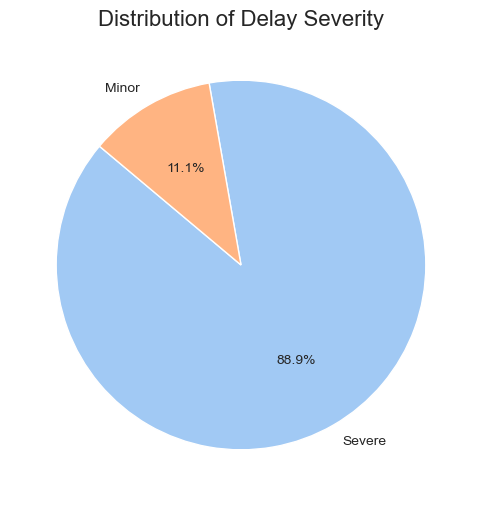

Foundational EDA complete.

--- Step 3: Generating Deeper EDA Visualizations ---


C:\Users\krish\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\krish\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


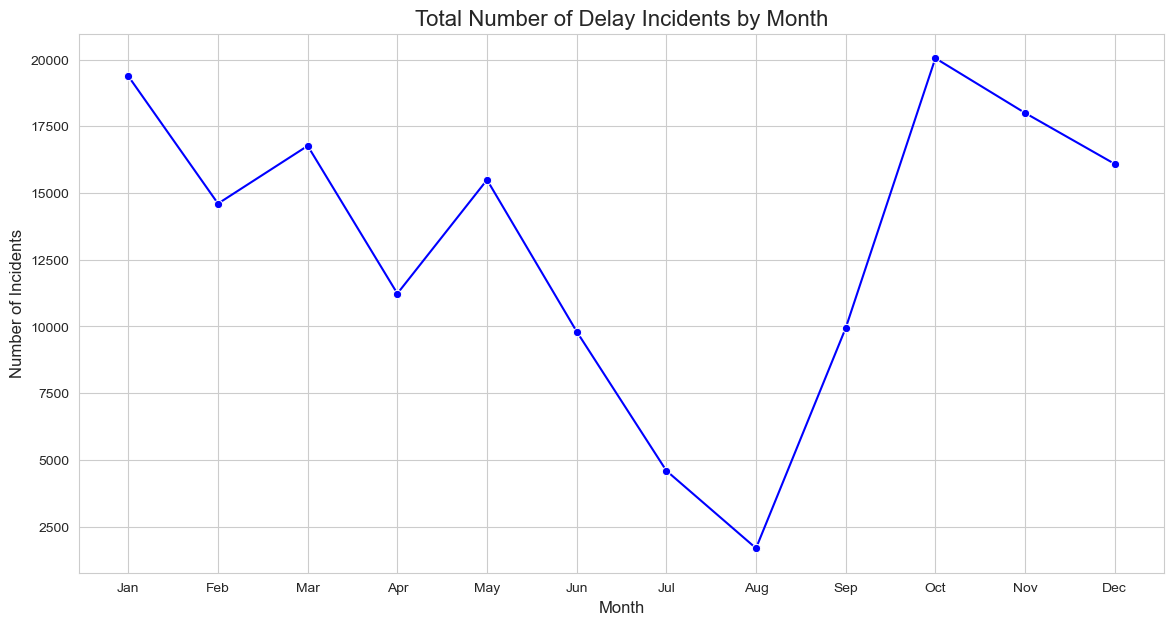

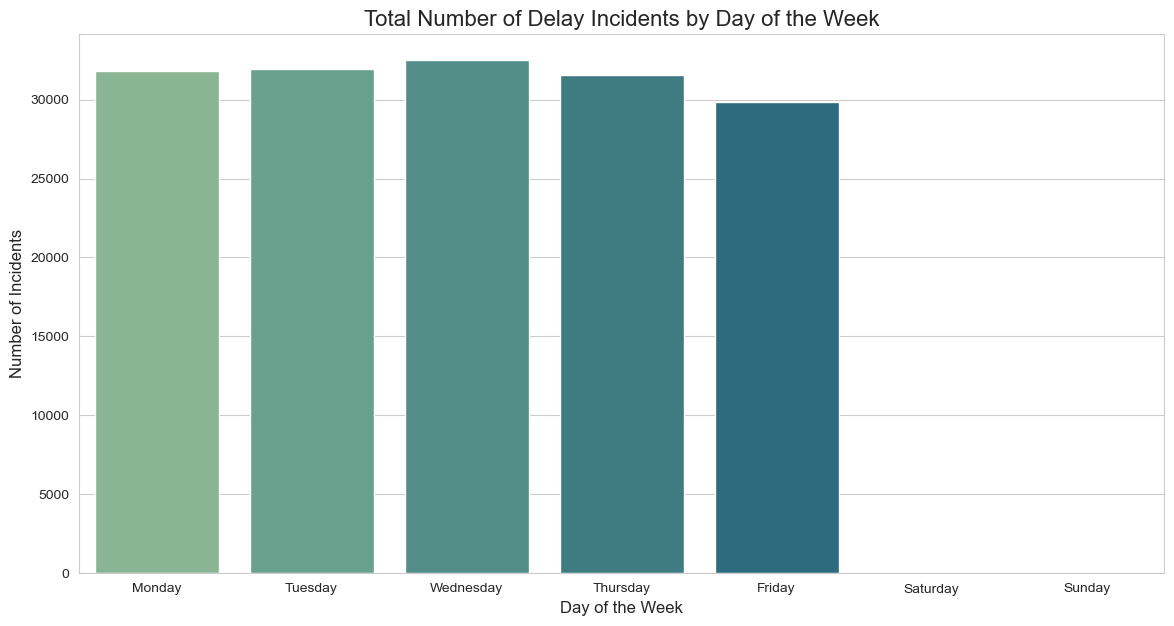

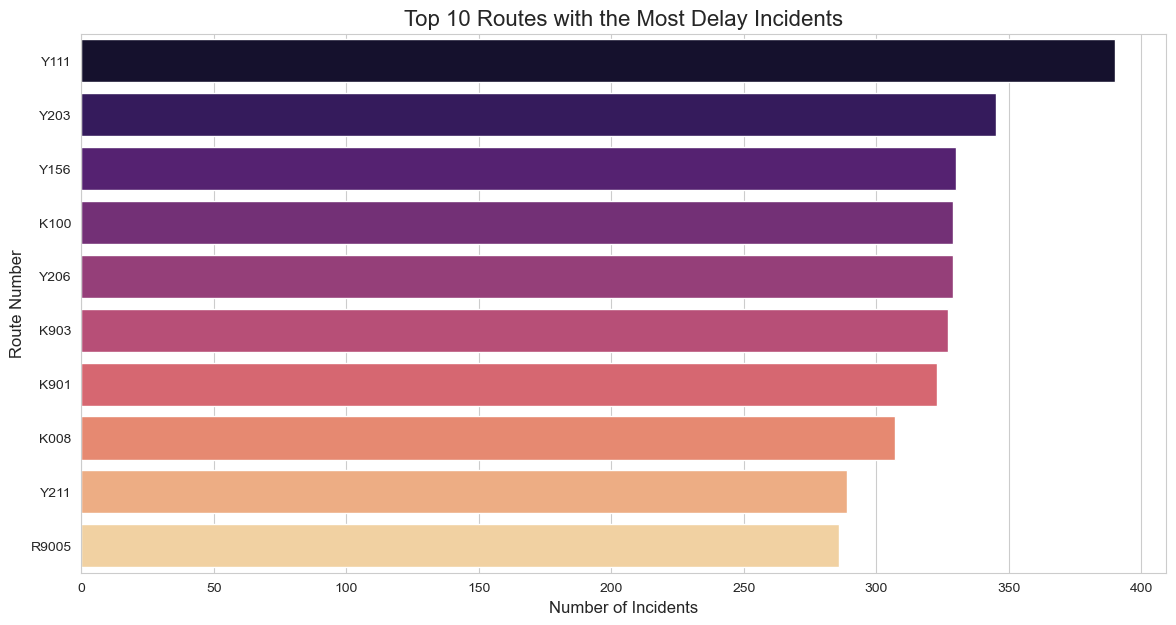

Deeper EDA complete.

--- Step 4: Building Classification Model (Predicting Severity) ---

--- Classification Model Evaluation ---
Accuracy: 0.8456194886760134

Classification Report:
               precision    recall  f1-score   support

       Minor       0.41      0.90      0.57      3508
      Severe       0.99      0.84      0.91     28018

    accuracy                           0.85     31526
   macro avg       0.70      0.87      0.74     31526
weighted avg       0.92      0.85      0.87     31526



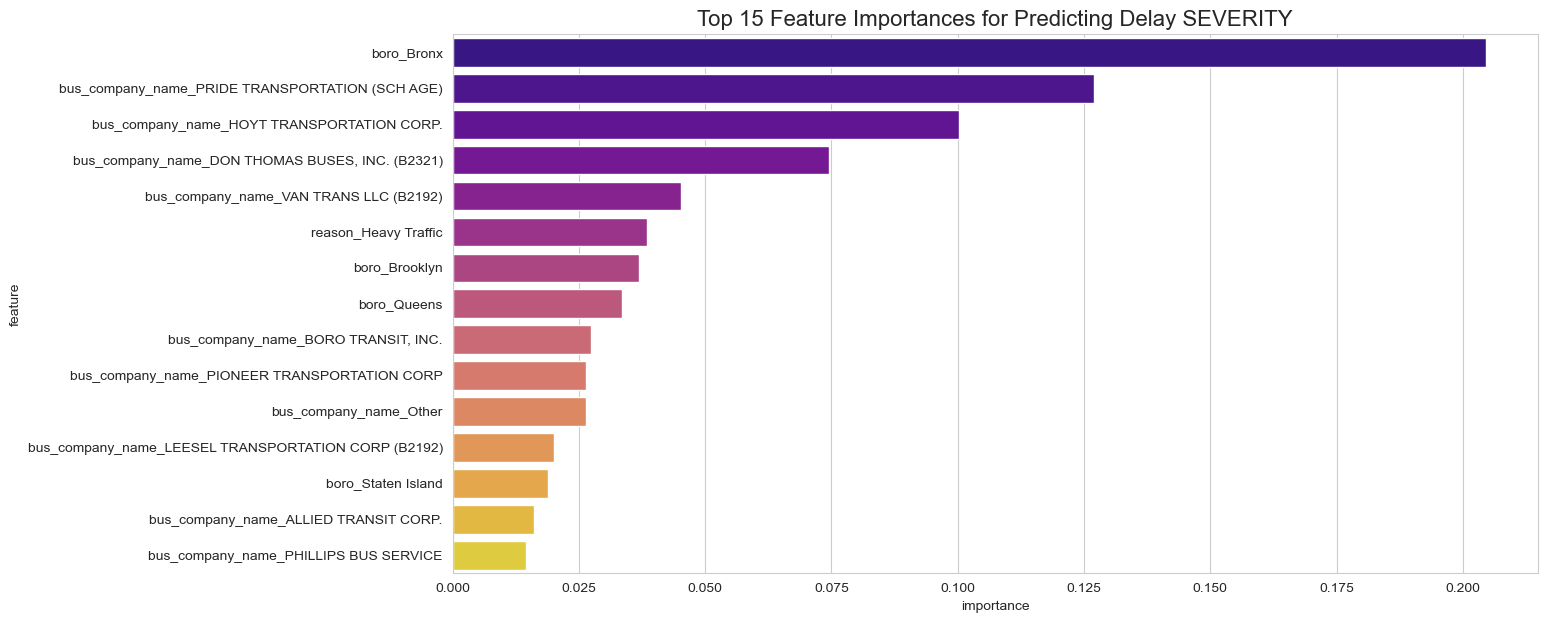

Classification model complete.

--- Step 5: Building Regression Model (Predicting Duration) ---

--- Regression Model Evaluation ---
Mean Absolute Error (MAE): 704.47 minutes
R-squared (R²): 0.72


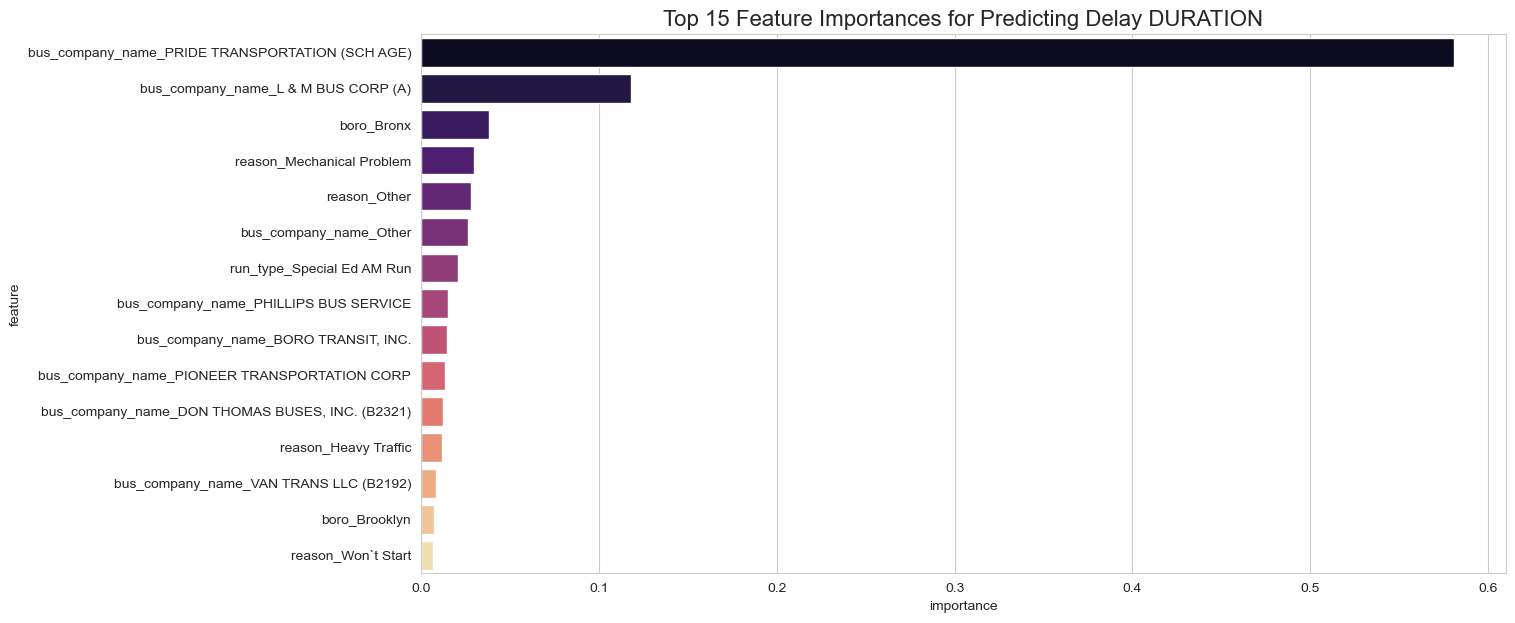

Regression model complete.

--- Comprehensive Analysis Finished ---


In [2]:
# --------------------------------------------------------------------------
# Comprehensive Business Analytics: Bus Breakdown and Delay Analysis
#
# Objective: To provide a complete, end-to-end analysis of bus breakdown data.
# This script includes all foundational and advanced EDA, as well as both
# a classification model (to predict severity) and a regression model
# (to predict exact delay duration).
# --------------------------------------------------------------------------

# --- 1. Import Libraries & Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, r2_score

# Set plot style for better aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# --- 2. Data Loading & Core Feature Engineering ---
print("--- Step 1: Loading Data & Performing Feature Engineering ---")

column_names = [
    'school_year', 'busbreakdown_id', 'run_type', 'bus_no', 'route_number', 'reason',
    'schools_serviced', 'occurred_on', 'created_on', 'boro', 'bus_company_name',
    'how_long_delayed', 'number_of_students_on_the_bus', 'has_contractor_notified_schools',
    'has_contractor_notified_parents', 'have_you_alerted_opt', 'informed_on', 'incident_number',
    'last_updated_on', 'breakdown_or_running_late', 'school_age_or_prek'
]
try:
    df = pd.read_csv('Bus_Breakdown_and_Delays_20251008.csv', header=0, names=column_names, low_memory=False)
except FileNotFoundError:
    print("Error: 'Bus_Breakdown_and_Delays_20251008.csv' not found.")
    exit()

# --- Feature Engineering ---
# Convert to datetime and extract time-based features
df['occurred_on'] = pd.to_datetime(df['occurred_on'], errors='coerce')
df.dropna(subset=['occurred_on'], inplace=True)
df['month'] = df['occurred_on'].dt.month
df['day_of_week'] = df['occurred_on'].dt.day_name()

def convert_delay_to_minutes(delay_str):
    if pd.isna(delay_str) or not isinstance(delay_str, str): return np.nan
    delay_str = delay_str.lower()
    total_minutes = 0
    if 'hour' in delay_str:
        try:
            hours = int(''.join(filter(str.isdigit, delay_str.split('hour')[0])))
            total_minutes += hours * 60
        except (ValueError, IndexError): pass
    if 'min' in delay_str:
        try:
            parts = delay_str.split('min')[0].strip().split()
            minutes = int(''.join(filter(str.isdigit, parts[-1])))
            total_minutes += minutes
        except (ValueError, IndexError): pass
    return total_minutes if total_minutes > 0 else np.nan

df['delay_minutes'] = df['how_long_delayed'].apply(convert_delay_to_minutes)
df['delay_minutes'].fillna(df['delay_minutes'].median(), inplace=True)
df['boro'].fillna('Unknown', inplace=True)
df['reason'].fillna('Unknown', inplace=True)

# Create 'delay_severity' for classification model
def categorize_delay(minutes):
    if minutes < 30: return 'Minor'
    elif 30 <= minutes <= 60: return 'Moderate'
    else: return 'Severe'
df['delay_severity'] = df['delay_minutes'].apply(categorize_delay)

# Create 'estimated_cost' for financial analysis
cost_per_hour = 40
admin_cost = 10
df['estimated_cost'] = admin_cost + (df['delay_minutes'] / 60) * cost_per_hour
print("Data loading and feature engineering complete.\n")


# --- 3. Foundational Exploratory Data Analysis (EDA) ---
print("--- Step 2: Generating Foundational EDA Visualizations ---")

# Insight 1: Cost by Company
company_costs = df.groupby('bus_company_name')['estimated_cost'].sum().sort_values(ascending=False)
plt.figure()
sns.barplot(x=company_costs.head(10).values, y=company_costs.head(10).index, palette='Reds_r')
plt.title('Top 10 Bus Companies by Total Estimated Cost of Delays', fontsize=16)
plt.xlabel('Total Estimated Cost ($)', fontsize=12)
plt.ylabel('Bus Company Name', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.show()

# Insight 2: Reason for Delay
plt.figure()
reason_counts = df['reason'].value_counts().nlargest(10)
sns.barplot(y=reason_counts.index, x=reason_counts.values, palette='viridis')
plt.title('Top 10 Reasons for Bus Delays', fontsize=16)
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Reason for Delay', fontsize=12)
plt.show()

# Insight 3: Delay Severity Distribution
plt.figure(figsize=(8, 6))
severity_counts = df['delay_severity'].value_counts()
plt.pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Delay Severity', fontsize=16)
plt.ylabel('')
plt.show()
print("Foundational EDA complete.\n")


# --- 4. Deeper Exploratory Data Analysis (EDA) ---
print("--- Step 3: Generating Deeper EDA Visualizations ---")

# Insight 4: Time Series - Monthly Delays
plt.figure()
monthly_delays = df.groupby('month').size()
sns.lineplot(x=monthly_delays.index, y=monthly_delays.values, marker='o', color='b')
plt.title('Total Number of Delay Incidents by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Insight 5: Time Series - Daily Delays
plt.figure()
daily_delays = df.groupby('day_of_week').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.barplot(x=daily_delays.index, y=daily_delays.values, palette='crest')
plt.title('Total Number of Delay Incidents by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.show()

# Insight 6: Route-Level Performance
plt.figure()
route_delays = df['route_number'].value_counts().nlargest(10)
sns.barplot(x=route_delays.values, y=route_delays.index, palette='magma')
plt.title('Top 10 Routes with the Most Delay Incidents', fontsize=16)
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Route Number', fontsize=12)
plt.show()
print("Deeper EDA complete.\n")


# --- 5. Predictive Modeling Part A: Classification ---
print("--- Step 4: Building Classification Model (Predicting Severity) ---")
features = ['boro', 'bus_company_name', 'reason', 'run_type', 'school_age_or_prek']
target_class = 'delay_severity'
model_df_class = df.dropna(subset=features + [target_class]).copy()

# Limit cardinality for stability
top_companies = model_df_class['bus_company_name'].value_counts().nlargest(20).index
model_df_class['bus_company_name'] = model_df_class['bus_company_name'].where(model_df_class['bus_company_name'].isin(top_companies), 'Other')

X_c = model_df_class[features]
y_c = model_df_class[target_class]
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42, stratify=y_c)

preprocessor_c = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), features)])
pipeline_c = Pipeline(steps=[('preprocessor', preprocessor_c),
                             ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))])
pipeline_c.fit(X_train_c, y_train_c)
y_pred_c = pipeline_c.predict(X_test_c)

print("\n--- Classification Model Evaluation ---")
print("Accuracy:", accuracy_score(y_test_c, y_pred_c))
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_c))

# Feature Importances for Classification
ohe_feature_names_c = pipeline_c.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(features)
importances_c = pipeline_c.named_steps['classifier'].feature_importances_
feature_importance_df_c = pd.DataFrame({'feature': ohe_feature_names_c, 'importance': importances_c}).sort_values(by='importance', ascending=False)

plt.figure()
sns.barplot(x='importance', y='feature', data=feature_importance_df_c.head(15), palette='plasma')
plt.title('Top 15 Feature Importances for Predicting Delay SEVERITY', fontsize=16)
plt.show()
print("Classification model complete.\n")


# --- 6. Predictive Modeling Part B: Regression ---
print("--- Step 5: Building Regression Model (Predicting Duration) ---")
target_reg = 'delay_minutes'
model_df_reg = df.dropna(subset=features + [target_reg]).copy()

model_df_reg['bus_company_name'] = model_df_reg['bus_company_name'].where(model_df_reg['bus_company_name'].isin(top_companies), 'Other')

X_r = model_df_reg[features]
y_r = model_df_reg[target_reg]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

preprocessor_r = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), features)])
pipeline_r = Pipeline(steps=[('preprocessor', preprocessor_r),
                             ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))])
pipeline_r.fit(X_train_r, y_train_r)
y_pred_r = pipeline_r.predict(X_test_r)

print("\n--- Regression Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_r, y_pred_r):.2f} minutes")
print(f"R-squared (R²): {r2_score(y_test_r, y_pred_r):.2f}")

# Feature Importances for Regression
ohe_feature_names_r = pipeline_r.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(features)
importances_r = pipeline_r.named_steps['regressor'].feature_importances_
feature_importance_df_r = pd.DataFrame({'feature': ohe_feature_names_r, 'importance': importances_r}).sort_values(by='importance', ascending=False)

plt.figure()
sns.barplot(x='importance', y='feature', data=feature_importance_df_r.head(15), palette='magma')
plt.title('Top 15 Feature Importances for Predicting Delay DURATION', fontsize=16)
plt.show()
print("Regression model complete.\n")

print("--- Comprehensive Analysis Finished ---")
